# Short-term Humidity Model Test (V3)

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'FF01_GP101'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'DC_GT401_GM401'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
              FF01_GP101          12
temperatures  DC_GT401_GM401      13
              TA01_GT10X_GM10X    14
              DC_GT301_damped     11
              DC_GT301_outdoor    12
setpoints     TA01_GT10X_GM10X    14
humidity      TA01_GT10X_GM10X    15
              DC_GT401_GM401      13
sun           gsi                  1
              vol                  1
time          mod                  1
              doy                  1
dtype: int64





In [6]:
# remove single NAN
data = data.dropna(how='any')

In [7]:
# describe cols
data.describe().transpose()

count         mean         std  \
category     sensor_ID                                             
flow         TA01_GP101        256304.0  2350.241038  606.493897   
             FF01_GP101        256304.0  2239.858543  571.440347   
temperatures DC_GT401_GM401    256304.0    49.457756    3.449056   
             TA01_GT10X_GM10X  256304.0    20.744766    1.277303   
             DC_GT301_damped   256304.0    -5.075504    6.692206   
             DC_GT301_outdoor  256304.0    -5.044650    6.653595   
setpoints    TA01_GT10X_GM10X  256304.0    20.661791    0.752594   
humidity     TA01_GT10X_GM10X  256304.0    31.334455    9.570359   
             DC_GT401_GM401    256304.0     0.811782    0.980756   
sun          gsi               256304.0    29.613807   73.869865   
             vol               256304.0   341.133400  959.527867   
time         mod               256304.0     0.631367    0.306814   
             doy               256304.0     0.316664    0.202923   

                                        min          25%          50%  \
category     sensor_ID                                                  
flow         TA01_GP101        1.761400e+03  1860.000000  2059.000000   
             FF01_GP101        1.358800e+03  1788.900000  1957.100000   
temperatures DC_GT401_GM401    1.540000e+01    48.700000    50.200000   
             TA01_GT10X_GM10X  1.170000e+01    19.900000    20.300000   
             DC_GT301_damped  -2.160000e+01   -10.400000    -3.800000   
             DC_GT301_outdoor -2.090000e+01   -10.300000    -3.700000   
setpoints    TA01_GT10X_GM10X  2.000000e+01    20.000000    20.000000   
humidity     TA01_GT10X_GM10X  9.100000e+00    24.400000    30.400000   
             DC_GT401_GM401    0.000000e+00     0.100000     0.300000   
sun          gsi               0.000000e+00     0.000000     0.003810   
             vol               0.000000e+00     0.000000     0.000000   
time         mod               0.000000e+00     0.378649     0.697790   
             doy               1.224647e-16     0.128748     0.296713   

                                       75%          max  
category     sensor_ID                                   
flow         TA01_GP101        2738.400000  4206.600000  
             FF01_GP101        2600.800000  4043.600000  
temperatures DC_GT401_GM401      51.200000    56.200000  
             TA01_GT10X_GM10X    21.500000    29.800000  
             DC_GT301_damped      0.100000     9.300000  
             DC_GT301_outdoor     0.300000     8.400000  
setpoints    TA01_GT10X_GM10X    21.500000    22.100000  
humidity     TA01_GT10X_GM10X    37.700000    70.600000  
             DC_GT401_GM401       1.200000    13.600000  
sun          gsi                 10.347319   491.320000  
             vol                  0.253377  3600.000000  
time         mod                  0.917060     1.000000  
             doy                  0.501242     0.668064

## Process / transform variables 

In [8]:
# remove erroneous setpoints data
data = data[data.setpoints.TA01_GT10X_GM10X != 0.0]

# # set temp to adjusted for setpoint
# data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
#                                                 - (data.setpoints.TA01_GT10X_GM10X - 20.0)

# ## Use temperature Diff. w.r.t. setpoint
# #data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
# #    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# Transform setpoints variable to instead account for difference w.r.t 20 deg C
data[('temperatures', 'setpoint_diff')] = data.setpoints.TA01_GT10X_GM10X - 20.0

In [9]:
# remove "OUTLIERS" from DC-TEMP
# data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_diff')] = np.abs(data.temperatures.DC_GT401_GM401 - data.temperatures.DC_GT401_GM401_roll)
data.loc[data.temperatures.DC_diff > 2, ('temperatures', 'DC_GT401_GM401')] = data.temperatures.DC_GT401_GM401_roll

In [10]:
# remove "OUTLIERS" from DC-FLOW
data[('flow', 'TA01_GP101')] = data.flow.TA01_GP101.apply(lambda val: max(1800, val))

In [11]:
# perform FFT 
fourier = np.fft.rfft(data.temperatures.DC_GT401_GM401.values)

# get FREQS
spacing = 1 / 100 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1
fourier[freqs > threshold] = 0
filtered = np.fft.irfft(fourier)

# put in data
data.loc[:, ('temperatures', 'DC_GT401_GM401_fft')] = data[('temperatures', 'DC_GT401_GM401')]
data[('temperatures', 'DC_GT401_GM401_fft')] = filtered

In [12]:
# perform FFT 
fourier = np.fft.rfft(data.humidity.TA01_GT10X_GM10X.values)

# get FREQS
spacing = 1 / 10 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1 / 10
fourier[freqs > threshold] = 0
filtered = np.fft.irfft(fourier)

# put in data
data.loc[:, ('humidity', 'TA01_GT10X_GM10X_fft')] = data[('humidity', 'TA01_GT10X_GM10X')]
data[('humidity', 'TA01_GT10X_GM10X_fft')] = filtered

In [13]:
# perform FFT 
fourier = np.fft.rfft(data.humidity.DC_GT401_GM401.values)

# get FREQS
spacing = 1 / 10 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1 / 10
fourier[freqs > threshold] = 0
filtered = np.fft.irfft(fourier)

# put in data
data.loc[:, ('humidity', 'DC_GT401_GM401_fft')] = data[('humidity', 'DC_GT401_GM401')]
data[('humidity', 'DC_GT401_GM401_fft')] = filtered
data[('humidity', 'DC_GT401_GM401_fft')] = data.humidity.DC_GT401_GM401_fft.apply(lambda val: max(0, val))

### Plot pairwise correlation matrix

In [14]:
# corr = data.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))

# plt.figure(figsize=(12, 6))
# sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

# plt.xticks(rotation=45)
# plt.title('Pairwise correlation plot')
# plt.show()

# # delete correlation data
# del corr

## Preparing data

In [15]:
t_steps = 20  # 10 minute predictions
n_steps = 30  # 15 minute backwards look

train_frac = 0.8

### Data selection and whitening

In [16]:
# # save temp mean & std

# temp_mean = data.temperatures.TA01_GT10X_GM10X.mean()
# temp_std = data.temperatures.TA01_GT10X_GM10X.std()

In [17]:
# # normalize all columns
# for col in data.columns:
#     data[col] = (data[col] - data[col].mean()) / data[col].std()

In [18]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'FF01_GP101'),
    ('temperatures', 'DC_GT401_GM401_fft'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('temperatures', 'setpoint_diff'),
    ('humidity', 'TA01_GT10X_GM10X_fft'),
    ('humidity', 'DC_GT401_GM401_fft'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter data
data = data[model_vars]

In [19]:
# define target
targets = data[('humidity', 'TA01_GT10X_GM10X_fft')].copy().shift(periods=-t_steps)

# push "temp" forward with Gaussian noise due to assumption of near-perfect temp predictions
data[(('temperatures', 'TA01_GT10X_GM10X'))] = \
    data[(('temperatures', 'TA01_GT10X_GM10X'))].shift(periods=-t_steps)\
    + np.random.normal(0, 0.2)

# remove NaNs
targets = targets.iloc[:-t_steps]
data = data.iloc[:-t_steps]

### Create sequences

In [20]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['minute'] = data.index.get_level_values(3).values
    data['date_flag'] = data.minute - data.minute.shift(periods=n_steps) > n_steps / 2

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['minute'], data['date_flag']
    
    return flagged_idx

In [21]:
# get all n_step-sequences from data series
sequences = np.stack([
    data.values[i:i+n_steps, :] for i in range(len(data) - n_steps)
]) 

# get flagged sequences
flags = date_flagger(data, n_steps)

# get mask f. flags
mask = [idx not in flags for idx in range(len(sequences))]
sequences = sequences[mask]

# get targets, delete mask
targets = targets.values[n_steps:][mask]

In [22]:
# delete data 
del data

# save sequential seqs, targets for testing
sequences, test_seqs  = sequences[:-8640], sequences[-8640:]
targets, test_targets = targets[:-8640], targets[-8640:]

### Shuffle and split dataset

In [23]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
sequences = np.squeeze(sequences[idxs])
targets = np.squeeze(targets[idxs])


In [24]:
# split data
train_n = int(len(targets) * train_frac)
#test_n = len(targets) - train_n

X_train, X_test = sequences[:train_n], sequences[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [25]:
# delete vars
del sequences, targets

## Define model

In [26]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        activation='tanh',
        return_sequences=True,
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(
        units=64,
#         activation=None,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=64,
#         activation=None,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [27]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 13)           52        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 30, 32)            5888      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 32)           128       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128   

In [28]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/20
1238/1238 [==============================] - 88s 66ms/step - loss: 227.0764 - val_loss: 12.3746
Epoch 2/20
1238/1238 [==============================] - 90s 73ms/step - loss: 13.0449 - val_loss: 12.1448
Epoch 3/20
1238/1238 [==============================] - 85s 69ms/step - loss: 12.7458 - val_loss: 11.7867
Epoch 4/20
1238/1238 [==============================] - 99s 80ms/step - loss: 12.4391 - val_loss: 11.6787
Epoch 5/20
1238/1238 [==============================] - 107s 87ms/step - loss: 12.3077 - val_loss: 11.6106
Epoch 6/20
1238/1238 [==============================] - 168s 136ms/step - loss: 12.1619 - val_loss: 11.5799
Epoch 7/20
1238/1238 [==============================] - 168s 136ms/step - loss: 12.1147 - val_loss: 11.3135
Epoch 8/20
1238/1238 [==============================] - 168s 136ms/step - loss: 12.0540 - val_loss: 11.1617
Epoch 9/20
1238/1238 [==============================] - 168s 136ms/step - loss: 11.9966 - val_loss: 11.5468
Epoch 10/20
1238/1238 [=============

In [29]:
model_name = 'humid_model_v3'
model.save(save_path + model_name)

INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\humid_model_v3\assets


INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\humid_model_v3\assets


In [30]:
preds = model.predict(X_test)
vis_preds = model.predict(test_seqs)

270/270 [==============================] - 2s 7ms/step


In [31]:
test_mae = np.abs(np.squeeze(preds) - Y_test) 
temp_diffs = test_mae# * temp_std

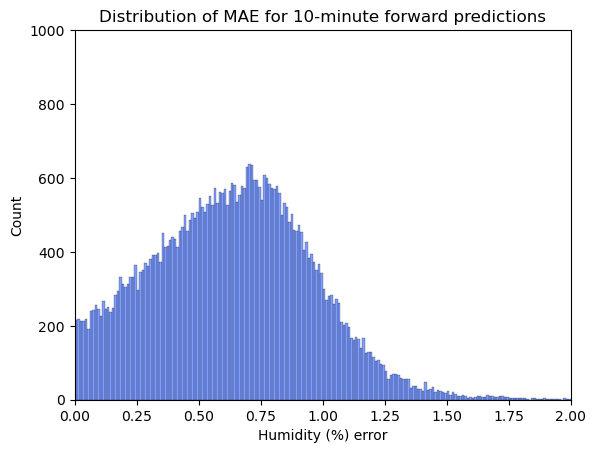

In [32]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 2.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of MAE for 10-minute forward predictions')
plt.xlim(0, 2.0)
plt.xlabel('Humidity (%) error')
plt.ylim(0, 1000)

#plt.savefig(plot_path + 'humid_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

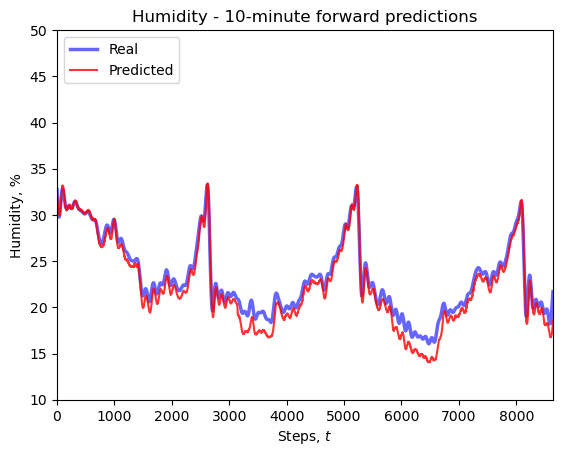

In [33]:
plt.plot(
    np.squeeze(test_targets),# * temp_std + temp_mean,
    c='b',
    alpha=0.6,
    linewidth=2.5,
    label='Real'
)

plt.plot(
    vis_preds,# * temp_std + temp_mean,
    c='r',
    alpha=0.8,
    linewidth=1.5,
    label='Predicted'
)

plt.ylabel('Humidity, %')
plt.xlabel('Steps, $t$')
plt.legend(loc='upper left')
plt.title('Humidity - 10-minute forward predictions')

plt.ylim(10, 50)
plt.xlim(0, len(vis_preds))

#plt.savefig(plot_path + 'humid_preds_10min.png', bbox_inches='tight', dpi=200)
plt.show()

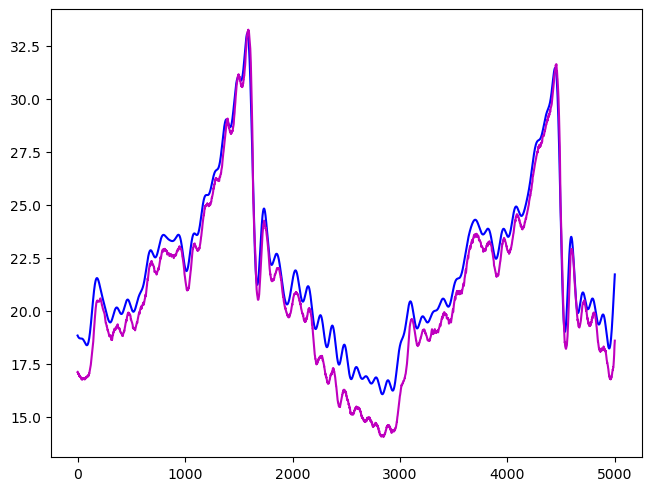

In [34]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(np.squeeze(test_targets)[-5000:], c='b')
ax.plot(vis_preds[-5000:], c='m')

# ax_sec = ax.twinx()

# ax_sec.plot(test_seqs[-8000:, 0, 0], c='r', linewidth=1.5, alpha=0.8)
# ax_sec.set_ylim(0, 5000)

plt.show()

In [35]:
np.corrcoef(test_targets, np.squeeze(vis_preds))

array([[1.        , 0.99486628],
       [0.99486628, 1.        ]])

In [36]:
np.corrcoef(np.squeeze(preds), Y_test)

array([[1.        , 0.99922697],
       [0.99922697, 1.        ]])